$$\normalsize{Задача \hspace{0.5cm} №1}$$
Напишите код, который используя метод Монте-Карло расчитывал бы цену опциона EKI/KO.
EKI/KO опцион это Европейский опцион, для которого добавлено два барьера. Непрерывный барьер - действует точно так же как в KO опционе. EKI барьер действует только в момент экспирации опциона : для call опциона выплота происходит только если курс актива на момент экспирации больше уровня EKI, для опциона put выплата происходит только если курс ниже уровня EKI на момент экпирации. Сделайте расчет для опциона call с параметрами указанными ниже:


In [4]:
#PARAMETERS
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
B = 110  #continues barrier level
EKI = 90 # EKI level
M = 360  #number of steps in time
I = 1000 #50000 # number of paths to generate

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
lw = 4 # line width
fs = 16  # fontsize
picWidth=10; picHeight=6

In [6]:
def eki(S, K, B, EKI):
    return np.maximum(S - EKI, K - EKI)*np.where((B - S) * (S - EKI) > 0, 0, 1)

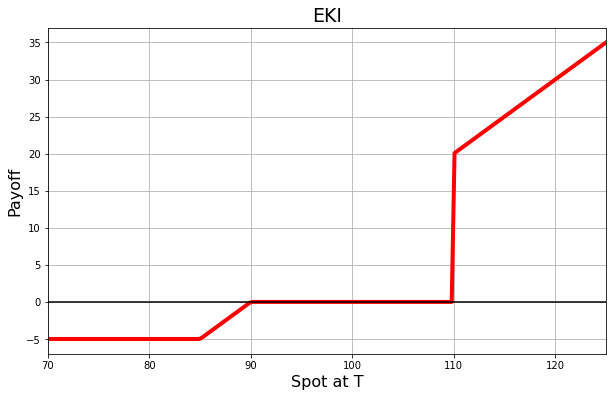

In [9]:
xmin, xmax = K-15, K+40
x = np.linspace(xmin, xmax, num=200)
y = eki(x, K, B, EKI)

plt.figure(figsize=(picWidth, picHeight))
plt.plot(x, y, 'r', linewidth=lw)
plt.axhline(0, color='k')
axes = plt.gca()
axes.set_xlim([xmin, xmax])
plt.title('EKI', fontsize=fs+3)
plt.ylabel('Payoff', fontsize=fs)
plt.xlabel('Spot at T', fontsize=fs)
plt.grid(True)

$ 
C_0 = E\left[ e^{-rT} max(S_{t} - EKI, K - EKI) * \chi\left(\{ S_{t} | S_{t} > B, S_{t} < EKI\} \right)\right], \hspace{0.2cm} \chi $ - функция Хевисайда 

$S(t) = S_{0} \exp(r t - \frac{1}{2} \sigma^2 t + \sigma W_t), \hspace{0.2cm} W_{t + dt} - W_{t} $ ~ $ N(0, dt) = \sqrt{dt} N(0, 1)$

In [130]:
def mc_call_pv_with_paths0(S0, K, T, r, sigma, M, I):
    # Simulating I paths with M time steps
    S = np.zeros((M + 1, I))
    C = np.zeros(I)
    S[0] = S0
    dt = float(T) / M
    for t in range(1, M + 1):
        z = np.random.standard_normal(I)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    
    for i in range(1, I):
        C[i] = np.exp(-r * T) * eki(S[M][i], K, B, EKI)
    
    # PV is extected discounted payoff
    C_aggr = np.sum(np.exp(-r * T) * eki(S[M], K, B, EKI)) / I
    return C_aggr, S, C 

#calculating path of S and price of the option C
C_aggr, SPaths, C = mc_call_pv_with_paths0(S0, K, T, r, sigma, M, I)

EKI Call option price 0.2966008249683514


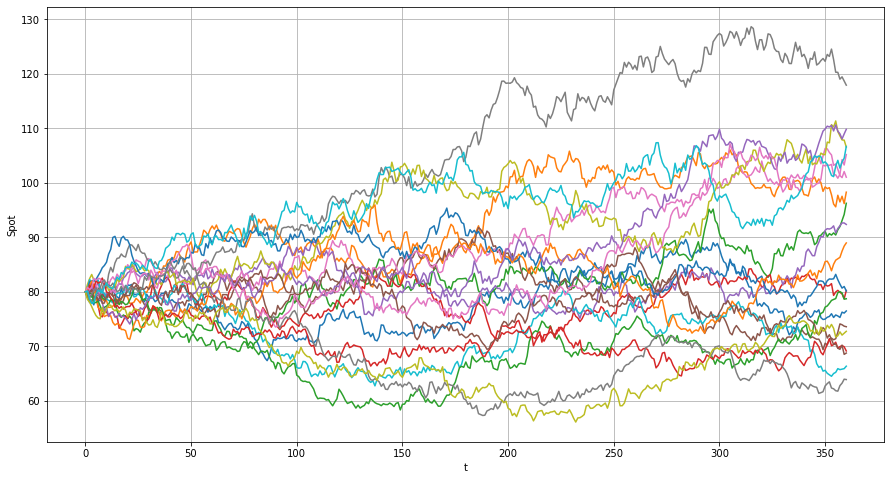

In [125]:
plt.figure(figsize=(15,8))
plt.plot(SPaths[:, :20])
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Spot')
print ('EKI Call option price', C_aggr)

EKI Call option price -0.9272140767330433


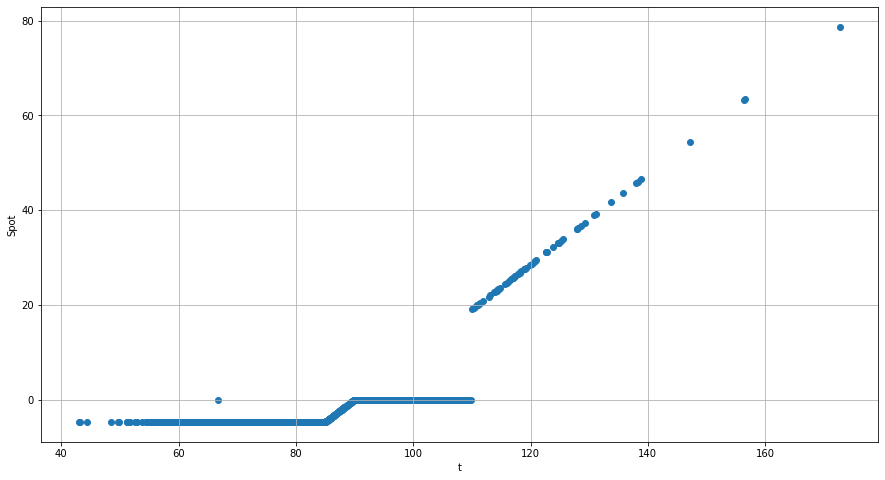

In [131]:
plt.figure(figsize=(15,8))
plt.scatter(SPaths[::1][M], C[::1])
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Spot')
print ('EKI Call option price', C_aggr)
#for I = 50000 dots are very very close
#for B = 110 price is negative

Для порога $B = 110$, цена опцина -- отрицательная, потому что точки сгущены плотнее при отрицательном pay-off, 
если, допустим, $B = 100$, то цена уже положительная.

$$\normalsize{Задача \hspace{0.5cm} №2}$$
Рассмотрим такую стратегию динамического хеджирования: в начальный момент времени мы покупаем базовый актив, в колличестве равном дельте call опциона. Далее мы перебалансируем наш портфель с каким-то шагом по времени. На каждом шаге мы покупаем или продаем базовый актив из такого расчета, что бы у нас на балансе опять был базовый актив, в колличестве равном дельте call опциона, с учетом изменившегося курса актива.

Используя симмуляции возможных реализаций процесса цены актива как в методе Монте-Карло сделайте код, который нарисует график для суммарной стоимости владания такой стратегией для некоторого кол-ва симмуляций.

График должен представлят из себя диаграмму рассеяния (scatter plot) в координатах x=ST, y=TotalProfitT

Параметры для расчета:


In [10]:
#PARAMETERS
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
M = 360 # number of steps in time
I = 1000 # number of paths to generate

$S_{0} \dfrac{\partial C_{0}}{\partial S_{0}} = e ^ {- r t}\left(S_{t} \dfrac{\partial C_{t}}{\partial S_{t}} + \alpha S_{t}\right)$ - стратегия хеджирования, где $0$ и $t$ - начальный и последующий шаги по времени. 
Запишем явную численную схему, из которой найдем $\alpha^{\tau + 1}$:
$$
S^{\tau} \dfrac{C^{\tau}\left(S^{\tau} + \delta S\right) - C^{\tau}\left(S^{\tau} - \delta S\right)}{2 \delta S} =  e ^ {- r t}\left(S^{\tau + 1} \dfrac{C^{\tau + 1}\left(S^{\tau + 1} + \delta S\right) - C^{\tau + 1}\left(S^{\tau + 1} - \delta S\right)}{2 \delta S} + \alpha^{\tau + 1} S^{\tau + 1}\right)
$$

In [11]:
def call_payoff(K, S):
    return np.maximum(S - K, 0)

In [60]:
def call_deriv(K, S):
    delta_S = 1 #let's tweak the underlying asset price
    return (call_payoff(K, S + delta_S) - call_payoff(K, S - delta_S)) / (2.0 * delta_S)

In [64]:
# Значение spot на текущем шаге симуляции 
S_cur = np.full(I, S0)
#Начальное значение портфеля = 0, так как dC/dS = 0 при S = 80, K = 85!!!
P = np.full(I, S0 * call_deriv(K, S0))

#pay_off = P_cur
dt = float(T) / M
for t in range(1, M + 1):
    z = np.random.standard_normal(I) #I - size of the array
    S_nxt = S_cur * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z) #next step
    #P = S_cur * call_deriv(K, S_cur)
    alpha_nxt = (P * np.exp(r * dt) - S_nxt * call_deriv(K, S_nxt)) / S_nxt
    P += alpha_nxt * S_nxt
    S_cur = S_nxt
 

mean portfolio -2.645957935683444e+107


Text(0, 0.5, 'portfolio')

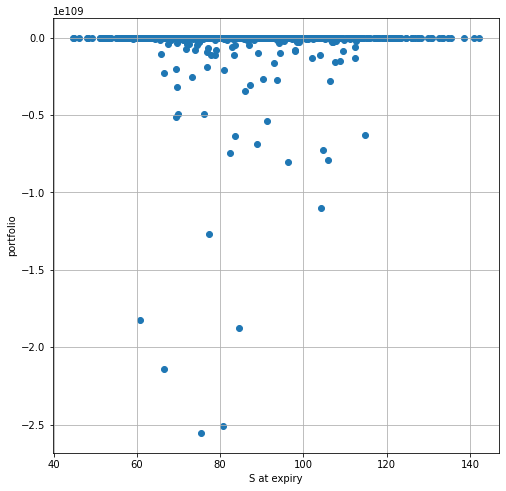

In [66]:
plt.figure(figsize=(8,8))
plt.scatter(S_nxt, P - S0 * call_deriv(K, S0))
plt.grid(True)
plt.xlabel('S at expiry')
plt.ylabel('portfolio')